**LoRA** makes a small change in the fine-tuning process. Instead of computing gradients for all the entries in W (which is huge), and updating all the parameters, it’s algorithm works as follows:
- Freeze the original parameters W at the start of fine-tuning.
- Decomposes W into two smaller matrices A and B, and update these two small matrices during fine-tuning. The decomposed matrices are significantly smaller in size than the original weight matrix W, and can easily fit into the memory. The decomposition is done in such a way that we can regenerate W from A and B. Basically A and B are LD, so the resulting LI matrix (That it is W) can be composed from A and B
- Once fine-tuning is completed, the smaller matrices A and B get adapted for the specific task.
- The important thing to note here is that the pretrained weights are not changed during this process as they were frozen by LoRA. The question arises now that how do we use the adapted matrices A and B to do the inference on a new input. Previously with normal finetuning/pretraining, if input to the model was x, the output of layer used to be W.x. But after fine-tuning the model with LoRA, the updated inference equation is:

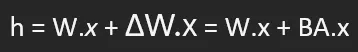

where 𝑥 is the input, 𝑊 represents model parameters, 𝐵 and 𝐴 represent low-rank adapters trained during LoRA fine-tunin

The amount of memory saved depends on the rank r, a hyperparameter. For instance, if ΔW has 10,000 rows and 20,000 columns, it holds 200,000,000 parameters. Choosing A and B with r=8, A would have 10,000 rows and 8 columns, and B would have 8 rows and 20,000 columns, resulting in 10,000×8 + 8×20,000 = 240,000 parameters, which is approximately 830 times fewer than 200,000,000.

In [ ]:
!pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu121

In [ ]:
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

In [ ]:
!pip install --no-deps "xformers<0.0.27" "trl<0.9.0" peft accelerate bitsandbytes

In [ ]:
import torch
from trl import SFTTrainer
from datasets import load_dataset
from transformers import TrainingArguments, TextStreamer
from unsloth.chat_templates import get_chat_template
from unsloth import FastLanguageModel, is_bfloat16_supported
import pandas as pd
import sklearn
import triton

### Get env Ready
Lets set the bucket name and model name where you have all your datasets

In [ ]:
# Enter the bucket and model name
bucket_name = input("Enter bucket name:")
model_name = input("Enter model name:")

In [ ]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

print(f"{bcolors.HEADER} ---ENV REPORT-- {bcolors.ENDC}")
if torch.cuda.is_available():
    print(f"{bcolors.OKGREEN} CUDA {bcolors.ENDC} cores ")
    print(f"{bcolors.BOLD} GPUs: {torch.cuda.device_count()} {bcolors.ENDC}\n")
else:
    print(f"{bcolors.OKBLUE} Using CPU cores {bcolors.ENDC}")

print(f"{bcolors.OKCYAN}LIBRARIES{bcolors.ENDC}")
print(f"PyTorch version: {torch.__version__}")
print(f"Triton version: {triton.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")

### The rank in LoRa Fine tuning
A higher rank means a greater number of trainable parameters in our model, making fine-tuning more memory intensive. However, higher ranks retain more information from the original weight matrix, as the decomposed matrices themselves are large and capture most of the essence of W (i.e., the model becomes more expressive). We can say that, as the rank increases, LORA essentially converges toward normal fine-tuning.
### Alpha in LoRa
A higher “alpha” would place more emphasis on the low-rank structure or regularization, while a lower “alpha” would reduce its influence, making the model rely more on the original parameters. Adjusting “alpha” helps in striking a balance between fitting the data and preventing overfitting by regularizing the model.

As a rule of thumb, it’s usually common to choose an alpha that is twice as large as the rank when fine-tuning LLMs (note that this is different when working with diffusion models).

In [ ]:
## LoRa
rank= 8
alpha= 16
dropout=0

## Model
model_id = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit" ## Chose your preferred model

max_seq_length = 2048
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_id,
    max_seq_length=max_seq_length,
    load_in_4bit=True,
    dtype=None,
)

In [ ]:
# Print the configuration with colors
print(f"{bcolors.HEADER}## LoRa{bcolors.ENDC}")
print(f"{bcolors.OKGREEN}rank{bcolors.ENDC} = {bcolors.OKBLUE}{rank}{bcolors.ENDC}")
print(f"{bcolors.OKGREEN}alpha{bcolors.ENDC} = {bcolors.OKBLUE}{alpha}{bcolors.ENDC}\n")

print(f"{bcolors.HEADER}## Model{bcolors.ENDC}")
print(f"{bcolors.OKGREEN}model_id{bcolors.ENDC} = {bcolors.OKBLUE}{model_id}{bcolors.ENDC}")

### Test the model without training

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r=rank,
    lora_alpha=alpha,
    lora_dropout=dropout,
    target_modules=["q_proj", "k_proj", "v_proj", "up_proj", "down_proj", "o_proj", "gate_proj"], 
    use_rslora=True,
    use_gradient_checkpointing="unsloth"
)

FastLanguageModel.for_inference(model)

messages = [
    {"role": "human", "content": "Which is the best wine for fishes??"},
]

inputs = tokenizer.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(inputs, streamer = text_streamer, max_new_tokens = 128)

### Templating for tokenization
When training the model we **must** set a template or use a custom one. In case we want to use a custom one feel free to do so, otherwise we can use one already established. For this iteration as we are using ```meta-llama/Meta-Llama-3.1-8B-Instruct``` we are using the instruct method

In [ ]:
import os
s3_endpoint = os.environ["AWS_S3_ENDPOINT"]
s3_secret = os.environ["AWS_SECRET_ACCESS_KEY"]
s3_access_key = os.environ["AWS_ACCESS_KEY_ID"]

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Create a dropdown widget
data_type_widget = widgets.Dropdown(
    options=['instructlab', 'labelstudio'],
    value=None,
    description='Dataset Format:',
    style={'description_width': 'initial'}
)

# Display the dropdown
display(data_type_widget)

# Function to handle the selection
def on_change(change):
    global data_type
    data_type = change['new']
    print(f"Selected format: {data_type}")

# Attach the function to the widget
data_type_widget.observe(on_change, names='value')

# Initial value of data_type
data_type = None

In [ ]:
if data_type == None:
    raise Exception("No format for dataset has been setted") 
print(f"Using dataset with format: {data_type}")

In [ ]:
if s3_access_key is None: raise TypeError(f"'S3_ACCESS_KEY_ID' env variable is not set")
if s3_secret is None: raise TypeError(f"'S3_SECRET_ACCESS_KEY' env variable is not set")

In [ ]:
if bucket_name == "": raise TypeError(f"'bucket_name' input variable is empty")
if model_name == "": raise TypeError(f"'model_name' input variable is empty")

In [ ]:
tokenizer = get_chat_template(
    tokenizer,
    mapping={"role": "from", "content": "value", "user": "human", "assistant": "gpt"},
    chat_template="chatml",
)

In [ ]:
### Load datasets
import boto3
from tqdm import tqdm
import json


session = boto3.session.Session()
s3_client = session.client('s3',
                           region_name='nyc3',
                           endpoint_url=s3_endpoint,
                           aws_access_key_id=s3_access_key,
                           aws_secret_access_key=s3_secret
                          )

def load_instruct_lab():
    ## Load under dataset variable
    paginator=s3_client.get_paginator('list_objects_v2')
    pages=paginator.paginate(Bucket=bucket_name,Prefix=f"datasets/labeled/instructlab/{model_name}")
    i=0
    dataset=[]
    for page in pages:
        page_objects = page.get('Contents', [])
        for obj in tqdm(page_objects,desc="Loading instructlab jsonl"):
            data = s3_client.get_object(Bucket=bucket_name, Key=obj.get('Key'))
            content =(data['Body'].read()).decode("utf-8")
            if(i>0 and type(content) is str):
                jsonl = json.loads(content)
                for row in jsonl:
                    user_content= row["instruction"]
                    assistant_content=row["output"]
                    dataset.append({
                        "messages":[
                            {
                                "value":user_content,
                                "from":"human"
                            },
                            {
                                "value":assistant_content,
                                "from":"gpt"
                            }
                        ],
                        "prompt_id":i,
                        "knowledge_base":row["taxonomy_path"]
                    })
            i+=1
    return dataset

In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

if data_type == "instructlab":
    full_path = f"{bucket_name}/datasets/labeled/instructlab/{model_name}"
    dataset = load_instruct_lab()
    df = pd.DataFrame(dataset)
    ### Load test & train datasets
    dataframe = Dataset.from_pandas(df).train_test_split(test_size=0.2)
    train_dataset= dataframe["train"]
    test_dataset=dataframe["test"]
else:
    full_path = f"{bucket_name}/datasets/labeled/llm/{model_name}"
    paginator=s3_client.get_paginator('list_objects_v2')
    pages=paginator.paginate(Bucket=bucket_name,Prefix=f"datasets/labeled/gemma/{model_name}")
    i=0
    dataset=[]
    for page in pages:
        page_objects = page.get('Contents', [])
        for obj in tqdm(page_objects,desc="Loading dataset"):
            data = s3_client.get_object(Bucket=bucket_name, Key=obj.get('Key'))
            content =(data['Body'].read()).decode("utf-8")
            if(i>0 and type(content) is str):
                annotation = json.loads(content)
                results=annotation.get("result")
                if(len(results) <= 0):
                    continue
                data = annotation.get("task").get("data")
                instruction= data.get("input")
                context = data.get("input2")
                response = results[0].get("value").get("text")[0]
                dataset.append(
                    {
                        "instruction":instruction,
                        "context":context,
                        "response":response
                    }
                )
            i+=1
    raise Exception(" Yet not implemented methodology apart from instructlab")

In [ ]:
first_sample = df.iloc[0]
print(f"Question: {first_sample['messages'][0]['value']}\n")
print(f"Answer: {first_sample['messages'][1]['value']}\n")
print(f"Knowledge base: {first_sample['knowledge_base']}\n")

In [ ]:
from transformers import AutoTokenizer, TrainingArguments,BitsAndBytesConfig,AutoModelForCausalLM

def apply_template(examples):
    messages = examples["messages"]
    text = [tokenizer.apply_chat_template(message, tokenize=False, add_generation_prompt=False) for message in messages]
    return {"text": text}
    
train_dataset = train_dataset.map(apply_template,batched=True)
test_dataset = test_dataset.map(apply_template,batched=True)

- Batch size refers to the number of training samples processed before the model's internal parameters (weights) are updated.
- Gradient accumulation is a technique where gradients are accumulated over several batches before updating the model weights.
- This effectively increases the batch size without needing extra memory. For example, if you have a batch size of 2 and accumulate gradients over 4 steps, it is equivalent to having a batch size of 8 in terms of gradient calculation

During training, instead of updating the model weights after each batch, the gradients are accumulated over the specified number of batches (accumulation steps). After these steps, the accumulated gradients are used to update the model weights.

The goal of weight decay is to prevent the model from overfitting by discouraging the weights from growing too large, which can help improve generalization on unseen data.

Warmup steps refer to an initial phase in the training process of a neural network, where the learning rate starts at a lower value and gradually increases to a predetermined maximum value over a set number of iterations or steps. 

Weight decay It involves adding a penalty to the loss function based on the magnitude of the model's weights. 

In [ ]:
import transformers
from trl import SFTTrainer

################
# Training
################
training_args = transformers.TrainingArguments(
    learning_rate=3e-4,
    lr_scheduler_type="linear",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    num_train_epochs=2,
    fp16=not is_bfloat16_supported(),
    bf16=is_bfloat16_supported(),
    logging_steps=10,
    optim="adamw_8bit",
    weight_decay=0.01,
    warmup_steps=10,
    output_dir="outputs",
    seed=0,
    evaluation_strategy="steps",  # Can be "steps" or "epoch"
    eval_steps=10,  # Perform evaluation every n steps
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss"
)

In [ ]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=False,
    args=training_args,
)

In [ ]:
### Check CUDA memory
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

In [ ]:
trainer.train()

In [ ]:
### Check CUDA memory
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

In [ ]:
model.save_pretrained_merged("model", tokenizer, save_method="merged_16bit")

In [ ]:
### Flush CUDA memory
import gc
torch.cuda.empty_cache()
gc.collect()

In [ ]:
### Check CUDA memory
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

In [ ]:
FastLanguageModel.for_inference(model)

messages = [
    {"from": "human", "value": "Which is the best wine to eat with fish??"},
]

inputs = tokenizer.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_tensors="pt",
).to("cuda")

In [ ]:
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(inputs, streamer = text_streamer, max_new_tokens = 300)

In [ ]:
FastLanguageModel.for_inference(model)

messages = [
    {"from": "human", "value": "¿Cuál es el tipo de vino apropiado para acompañar el marisco?"},
]

inputs = tokenizer.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_tensors="pt",
).to("cuda")

In [ ]:
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(inputs, streamer = text_streamer, max_new_tokens = 300)